# **Proyek Akhir: Membuat Model Sistem Rekomendasi Berita**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## **I. Pendahuluan**
Proyek ini bertujuan untuk membangun sistem rekomendasi berita menggunakan dua pendekatan utama: **Content-Based Filtering** dan **Collaborative Filtering**. Tujuannya adalah memberikan rekomendasi yang dipersonalisasi kepada pengguna berdasarkan konten berita dan riwayat interaksi mereka.

### **Menyiapkan Library yang Dibutuhkan**

In [1]:
# Untuk mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk analisis dan manipulasi data
import pandas as pd
import numpy as np
from collections import defaultdict

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pemodelan Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library untuk pemodelan Collaborative Filtering
# %pip install scikit-surprise -q
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split

# Mengatur opsi tampilan pandas
pd.set_option('display.max_columns', None)

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


## **II. Data Understanding**
Tahap ini berfokus pada pemuatan dan pemahaman awal terhadap dataset. Kita akan menggunakan dataset MIND-small dari Kaggle.

Sumber Dataset: **MIND: Microsoft News Recommendation Dataset** [https://www.kaggle.com/datasets/arashnic/mind-news-dataset]

### **Memuat Dataset**
Kita akan memuat file `news.tsv` dan `behaviors.tsv` ke dalam DataFrame pandas.

In [2]:
# Fungsi untuk memuat data dengan penanganan error
def load_data(file_path, column_names):
    """
    Memuat data dari file TSV ke dalam DataFrame pandas.
    
    Args:
        file_path (str): Path ke file tsv.
        column_names (list): Daftar nama kolom untuk DataFrame.
    
    Returns:
        DataFrame: DataFrame yang berisi data dari file.
    """
    try:
        df = pd.read_csv(file_path, sep='\t', names=column_names)
        print(f"File '{file_path}' berhasil dimuat.")
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. Pastikan path file sudah benar.")
        return None

# Path ke file dataset (sesuaikan jika perlu)
path_to_news = './MINDsmall_train/news.tsv'
path_to_behaviors = './MINDsmall_train/behaviors.tsv'

# Mendefinisikan nama kolom berdasarkan dokumentasi dataset
news_cols = ['News_ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title_Entities', 'Abstract_Entities']
behaviors_cols = ['Impression_ID', 'User_ID', 'Time', 'History', 'Impressions']

# Memuat data
df_news = load_data(path_to_news, news_cols)
df_behaviors = load_data(path_to_behaviors, behaviors_cols)

File './MINDsmall_train/news.tsv' berhasil dimuat.
File './MINDsmall_train/behaviors.tsv' berhasil dimuat.


### **Informasi Dasar Dataset**
Melihat beberapa baris pertama, informasi, dan statistik deskriptif dari data.

In [3]:
# Menampilkan 5 baris pertama dari data berita
if df_news is not None:
    print("Contoh Data Berita (df_news):")
    display(df_news.head())

# Menampilkan 5 baris pertama dari data perilaku
if df_behaviors is not None:
    print("\nContoh Data Perilaku (df_behaviors):")
    display(df_behaviors.head())

Contoh Data Berita (df_news):


,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."



Contoh Data Perilaku (df_behaviors):


,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [4]:
# Menampilkan informasi ringkas tentang DataFrame berita
if df_news is not None:
    print("Informasi df_news:")
    df_news.info()

# Menampilkan informasi ringkas tentang DataFrame perilaku
if df_behaviors is not None:
    print("\nInformasi df_behaviors:")
    df_behaviors.info()

Informasi df_news:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB

Informasi df_behaviors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Impression_ID  156965 non-null  int64 
 1   User_ID        156965 non-null  object
 2   Time           156965 non-null  object
 3   His

### **Exploratory Data Analysis (EDA)**
Melakukan analisis data eksplorasi untuk memahami distribusi data.

#### **Distribusi Kategori Berita**

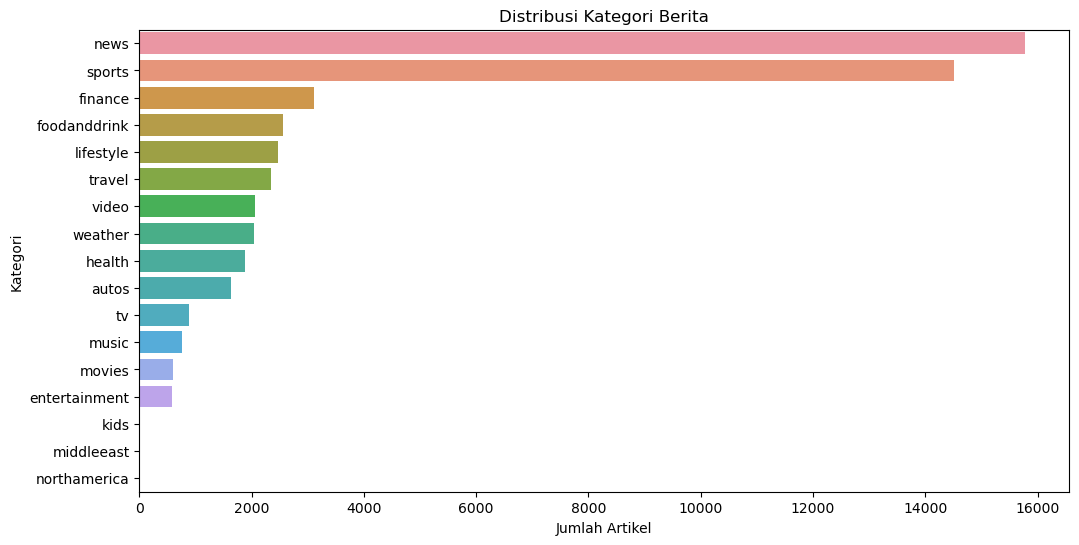

In [5]:
if df_news is not None:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='Category', data=df_news, order=df_news['Category'].value_counts().index)
    plt.title('Distribusi Kategori Berita')
    plt.xlabel('Jumlah Artikel')
    plt.ylabel('Kategori')
    plt.show()

#### **Distribusi Panjang Riwayat Baca Pengguna**
Visualisasi ini menunjukkan seberapa aktif para pengguna dalam membaca berita.

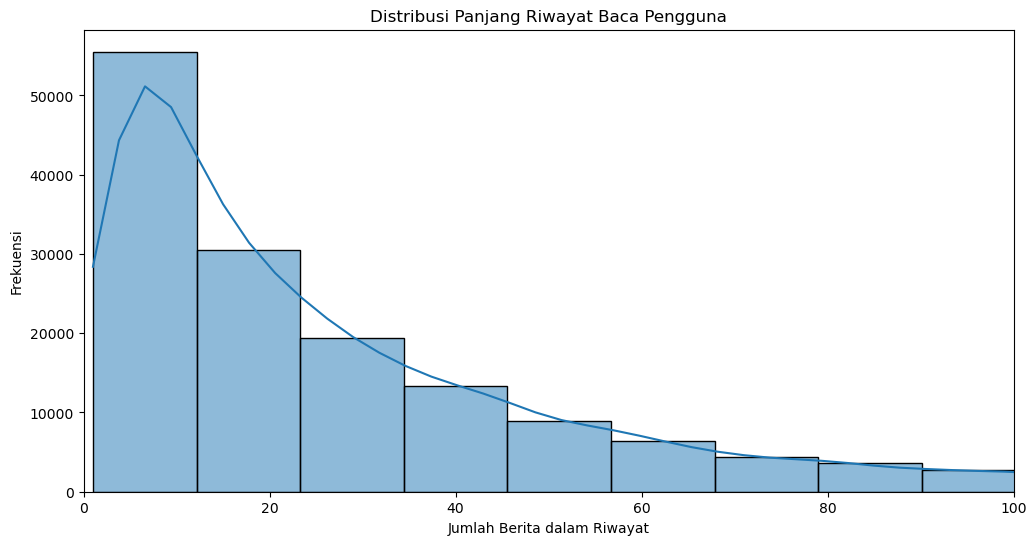

In [6]:
# Cek dulu apakah df_behaviors ada dan kolom History tidak kosong
if 'df_behaviors' in globals() and not df_behaviors['History'].isnull().all():
    # Menghitung panjang riwayat baca untuk setiap entri yang tidak null
    history_lengths = df_behaviors['History'].dropna().apply(lambda x: len(x.split()))

    plt.figure(figsize=(12, 6))
    sns.histplot(history_lengths, bins=50, kde=True)
    plt.title('Distribusi Panjang Riwayat Baca Pengguna')
    plt.xlabel('Jumlah Berita dalam Riwayat')
    plt.ylabel('Frekuensi')
    plt.xlim(0, 100) # Batasi sumbu x agar lebih mudah dibaca
    plt.show()

## **III. Data Preparation**
Menyiapkan data agar siap untuk proses pemodelan.

### **Membersihkan dan Menggabungkan Data**
Kita akan membersihkan data dari nilai null dan menggabungkan informasi yang relevan. Langkah ini krusial karena:
- **Pembersihan Data:** Memastikan tidak ada data yang hilang pada fitur-fitur kunci (`Title`, `Category`) yang dapat menyebabkan error atau hasil yang tidak akurat.
- **Sampling:** Mengambil sampel dari data perilaku dilakukan untuk mempercepat proses komputasi, terutama pada mesin dengan sumber daya terbatas, tanpa kehilangan representasi umum dari pola interaksi pengguna.
- **Penggabungan Data:** Menggabungkan data interaksi (`df_interaction`) dengan detail berita (`df_news_cleaned`) diperlukan agar kita memiliki informasi konten untuk setiap berita yang diklik pengguna.

In [7]:
if df_news is not None and df_behaviors is not None:
    # Membersihkan data berita dari nilai null pada kolom penting
    df_news_cleaned = df_news.dropna(subset=['Title', 'Category'])
    print(f"Jumlah data berita setelah dibersihkan: {len(df_news_cleaned)}")

    # Mengambil sampel data perilaku untuk mempercepat proses (opsional, bisa di-skip jika komputasi kuat)
    df_behaviors_sample = df_behaviors.sample(n=50000, random_state=42)

    # Memproses kolom 'History' untuk mendapatkan interaksi user-item
    user_history_list = []
    for index, row in df_behaviors_sample.iterrows():
        if isinstance(row['History'], str):
            history_ids = row['History'].split()
            for news_id in history_ids:
                user_history_list.append({'User_ID': row['User_ID'], 'News_ID': news_id})

    df_interaction = pd.DataFrame(user_history_list)
    print("Contoh data interaksi dari 'History':")
    display(df_interaction.head())

    # Menggabungkan data interaksi dengan data berita
    df_full_interaction = pd.merge(df_interaction, df_news_cleaned, on='News_ID', how='inner')
    print("Contoh data interaksi yang sudah digabungkan dengan detail berita:")
    display(df_full_interaction.head())

Jumlah data berita setelah dibersihkan: 51282
Contoh data interaksi dari 'History':


,User_ID,News_ID
0,U46778,N17157
1,U46778,N28081
2,U46778,N58641
3,U46778,N3926
4,U46778,N16290


Contoh data interaksi yang sudah digabungkan dengan detail berita:


,User_ID,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,U46778,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
1,U69760,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
2,U19468,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
3,U93306,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."
4,U34856,N17157,foodanddrink,foodnews,We Tried Fatburger's Impossible Burger. Here's...,We took a bite into the new Fatburger Impossib...,https://assets.msn.com/labs/mind/AAIxfTr.html,"[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W...","[{""Label"": ""Impossible Foods"", ""Type"": ""O"", ""W..."


## **IV. Modeling: Content-Based Filtering**
Membuat model yang merekomendasikan berita berdasarkan kemiripan konten.

In [8]:
# Mengambil data berita unik untuk model content-based
df_content = df_news_cleaned.drop_duplicates(subset=['News_ID']).reset_index(drop=True)

# Membuat fitur 'content' dengan menggabungkan judul dan kategori
df_content['content'] = df_content['Title'] + ' ' + df_content['Category']

# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan fit dan transform pada data 'content'
tfidf_matrix = tfidf.fit_transform(df_content['content'])

# Membuat Series untuk mencocokkan judul berita dengan indeksnya
indices = pd.Series(df_content.index, index=df_content['Title'])

print("TF-IDF Matrix berhasil dibuat. Matriks kemiripan akan dihitung secara dinamis.")

TF-IDF Matrix berhasil dibuat. Matriks kemiripan akan dihitung secara dinamis.


### **Fungsi Rekomendasi Content-Based**

In [9]:
def get_content_based_recommendations(title, tfidf_matrix, df, indices_map):
    """
    Memberikan rekomendasi berita berdasarkan kemiripan konten secara dinamis.
    
    Args:
        title (str): Judul berita yang menjadi referensi.
        tfidf_matrix (scipy.sparse.matrix): Matriks TF-IDF dari semua berita.
        df (DataFrame): DataFrame berisi data berita.
        indices_map (pd.Series): Mapping dari judul ke indeks.
        
    Returns:
        DataFrame: Daftar 10 berita yang direkomendasikan.
    """
    try:
        # Mendapatkan indeks dari judul berita yang diberikan
        idx = indices_map[title]
        
        # Menghitung cosine similarity HANYA untuk item yang dipilih (idx) terhadap semua item lain
        # Ini menghasilkan array (1, N) bukan (N, N), sehingga sangat hemat memori
        cosine_sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
        
        # Mengubahnya menjadi daftar skor
        sim_scores = list(enumerate(cosine_sim_scores[0]))
        
        # Mengurutkan berita berdasarkan skor kemiripan
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Mengambil 10 berita teratas (setelah berita referensi itu sendiri)
        sim_scores = sim_scores[1:11]
        
        # Mendapatkan indeks dari berita yang direkomendasikan
        news_indices = [i[0] for i in sim_scores]
        
        # Mengembalikan DataFrame dengan berita yang direkomendasikan
        return df[['Title', 'Category']].iloc[news_indices]
    
    except KeyError:
        return f"Error: Judul '{title}' tidak ditemukan dalam dataset."

# Contoh penggunaan
news_title_example = df_content['Title'].iloc[10] 
print(f"\nRekomendasi untuk berita dengan judul: '{news_title_example}'")

# Panggil fungsi dengan tfidf_matrix, bukan cosine_sim
recommendations = get_content_based_recommendations(news_title_example, tfidf_matrix, df_content, indices)
display(recommendations)


Rekomendasi untuk berita dengan judul: '50 Foods You Should Never Eat, According to Health Experts'


,Title,Category
4734,How Much Protein You Should Actually Eat in On...,health
2078,50 famous foods you should eat in your lifetime,foodanddrink
5929,50 Awful Foods That Should Never Be in Your Ki...,health
14023,3 Foods You Should Eat at Breakfast If You Wan...,health
1603,"The 5 worst dishes you can eat at buffet, acco...",health
29408,"10 Exercises You Should Never Do Again, Accord...",health
31261,100 Worst Foods to Eat When You're Sick,health
13086,21 Frozen Foods You Should Never Put in Your Cart,health
629,40 Health Symptoms You Should Never Ignore,health
29449,Heart Health Symptoms You Should Never Ignore,health


## **V. Modeling: Collaborative Filtering**
Membuat model yang merekomendasikan berita berdasarkan interaksi pengguna.

In [10]:
# Menyiapkan data untuk Surprise
# Menambahkan kolom 'rating' karena data kita implisit (klik = 1)
df_interaction['Rating'] = 1

# Inisialisasi Reader dari Surprise
reader = Reader(rating_scale=(1, 1))

# Memuat data ke dalam format dataset Surprise
data_surprise = Dataset.load_from_df(df_interaction[['User_ID', 'News_ID', 'Rating']], reader)

# Inisialisasi model SVD
svd = SVD(n_factors=50, n_epochs=20, random_state=42)

# Melatih model pada seluruh dataset
trainset = data_surprise.build_full_trainset()
svd.fit(trainset)

print("Model SVD (Collaborative Filtering) berhasil dilatih.")

Model SVD (Collaborative Filtering) berhasil dilatih.


### **Fungsi Rekomendasi Collaborative Filtering**

In [11]:
def get_collaborative_filtering_recommendations(user_id, model=svd, df_interact=df_interaction, df_n=df_news_cleaned):
    """
    Memberikan rekomendasi berita untuk pengguna tertentu.
    
    Args:
        user_id (str): ID pengguna.
        model: Model Surprise yang sudah dilatih.
        df_interact (DataFrame): DataFrame interaksi user-item.
        df_n (DataFrame): DataFrame berisi data berita.
        
    Returns:
        DataFrame: Daftar 10 berita yang direkomendasikan.
    """
    # Mendapatkan daftar berita yang sudah dibaca oleh pengguna
    read_news = df_interact[df_interact['User_ID'] == user_id]['News_ID'].unique()
    
    # Mendapatkan daftar semua berita unik
    all_news = df_n['News_ID'].unique()
    
    # Mendapatkan daftar berita yang belum dibaca oleh pengguna
    unread_news = [news for news in all_news if news not in read_news]
    
    # Memprediksi rating untuk berita yang belum dibaca
    predictions = [model.predict(user_id, news_id) for news_id in unread_news]
    
    # Mengurutkan prediksi berdasarkan estimasi rating tertinggi
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Mengambil 10 rekomendasi teratas
    top_n_preds = predictions[:10]
    
    # Mendapatkan ID berita dari rekomendasi
    top_n_news_ids = [pred.iid for pred in top_n_preds]
    
    # Mengembalikan detail berita dari ID yang direkomendasikan
    return df_n[df_n['News_ID'].isin(top_n_news_ids)][['Title', 'Category']]


# Contoh penggunaan
user_id_example = df_interaction['User_ID'].iloc[0]
print(f"Rekomendasi untuk pengguna dengan ID: {user_id_example}")
display(get_collaborative_filtering_recommendations(user_id_example))

Rekomendasi untuk pengguna dengan ID: U46778


,Title,Category
0,"The Brands Queen Elizabeth, Prince Charles, an...",lifestyle
1,50 Worst Habits For Belly Fat,health
2,The Cost of Trump's Aid Freeze in the Trenches...,news
3,I Was An NBA Wife. Here's How It Affected My M...,health
4,"How to Get Rid of Skin Tags, According to a De...",health
5,Should NFL be able to fine players for critici...,sports
6,It's been Orlando's hottest October ever so fa...,weather
7,Chile: Three die in supermarket fire amid prot...,news
8,Best PS5 games: top PlayStation 5 titles to lo...,entertainment
9,"How to report weather-related closings, delays",news


## **VI. Evaluation**
Mengevaluasi model rekomendasi menggunakan metrik **Precision@k**. Metrik ini dipilih karena sangat relevan untuk skenario Top-N recommendation, di mana tujuannya adalah menyajikan beberapa item teratas yang paling mungkin disukai pengguna. Kita akan mengevaluasi kedua model untuk membandingkan performanya.

### **Evaluasi untuk Collaborative Filtering**
Mengevaluasi model Collaborative Filtering menggunakan metrik Precision@k.

In [12]:
def precision_at_k(predictions, k=10, threshold=0.8):
    """
    Menghitung Precision@k dari daftar prediksi.

    Args:
        predictions (list): Daftar objek prediksi dari Surprise.
        k (int): Jumlah item rekomendasi.
        threshold (float): Batas rating untuk dianggap relevan (karena rating kita 1, threshold bisa < 1).

    Returns:
        float: Nilai Precision@k.
    """
    # Membuat map dari user ke list (est, true_r)
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = dict()
    for uid, user_ratings in user_est_true.items():
        # Mengurutkan berdasarkan prediksi rating tertinggi
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Menghitung jumlah item relevan di antara k rekomendasi teratas
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings[:k])
        # Menghitung precision untuk pengguna ini
        precisions[uid] = n_rel / k

    # Mengembalikan rata-rata precision dari semua pengguna
    return sum(prec for prec in precisions.values()) / len(precisions)

# Membagi data menjadi train dan test set
trainset, testset = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)

# Melatih model SVD pada trainset
svd_eval = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_eval.fit(trainset)

# Membuat prediksi pada testset
predictions = svd_eval.test(testset)

# Menghitung Precision@10
p_at_10 = precision_at_k(predictions, k=10)
print(f"Hasil evaluasi model Collaborative Filtering:")
print(f"Precision@10 = {p_at_10:.4f}")

Hasil evaluasi model Collaborative Filtering:
Precision@10 = 0.5312


### **Evaluasi untuk Content-Based Filtering**
Untuk mengevaluasi model Content-Based, kita akan menyimulasikan skenario berikut:
1.  Kita ambil riwayat baca setiap pengguna.
2.  Satu berita dari riwayatnya akan kita gunakan sebagai *input* untuk mendapatkan rekomendasi.
3.  Sisa riwayat bacanya akan kita anggap sebagai *ground truth* (berita yang relevan).
4.  Kita hitung berapa banyak dari berita yang direkomendasikan yang cocok dengan *ground truth* menggunakan metrik **Precision@10**.

In [13]:
def evaluate_content_based_model(df_interaction, tfidf_matrix, df_content, indices_map, k=10):
    """
    Mengevaluasi model Content-Based Filtering menggunakan Precision@k.
    """
    # Membuat dictionary riwayat baca per pengguna
    user_history = df_interaction.groupby('User_ID')['News_ID'].apply(list).to_dict()
    
    precisions = []
    
    # Ambil sampel user untuk evaluasi agar tidak terlalu lama
    user_ids_to_evaluate = list(user_history.keys())[:500] # Evaluasi pada 500 user pertama
    
    for user_id in user_ids_to_evaluate:
        history = user_history[user_id]
        
        if len(history) > 1:
            # Gunakan item pertama sebagai source, sisanya ground truth
            source_news_id = history[0]
            ground_truth_ids = set(history[1:])
            
            # Dapatkan judul dari source_news_id
            try:
                source_title = df_content[df_content['News_ID'] == source_news_id]['Title'].values[0]
            except IndexError:
                continue # Skip jika berita tidak ada di df_content (karena pembersihan/sampling)
                
            # Dapatkan rekomendasi
            recommendations_df = get_content_based_recommendations(source_title, tfidf_matrix, df_content, indices_map)
            
            # Jika rekomendasi valid (bukan string error)
            if isinstance(recommendations_df, pd.DataFrame):
                recommended_ids = set(df_content.loc[recommendations_df.index]['News_ID'])
                
                # Hitung jumlah item yang relevan (hits)
                hits = len(recommended_ids.intersection(ground_truth_ids))
                
                # Hitung precision
                precision = hits / k
                precisions.append(precision)

    # Rata-rata precision dari semua pengguna yang dievaluasi
    if not precisions:
        return 0.0
    return np.mean(precisions)

# Menghitung Precision@10 untuk model Content-Based
cb_precision = evaluate_content_based_model(df_interaction, tfidf_matrix, df_content, indices)
print(f"Hasil evaluasi model Content-Based Filtering:")
print(f"Precision@10 = {cb_precision:.4f}")

Hasil evaluasi model Content-Based Filtering:
Precision@10 = 0.0032
